# DeepWaveAccel simulation

### Load relevent libraries for DeepWaveAccel

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav

import Preprocess as pp
import Goertzel as g

### Load and preprocess dataset and training info

In [50]:
# Dataset
Df = pp.DataSet.from_file("/mnt/c/Users/bramh/Documents/UNI git/DeepWave/datasets/FRIDA/dataset/D_1-5_freq0_cold.npz") # proprocessed dataset from DeepWave
Pf = np.load("/mnt/c/Users/bramh/Documents/UNI git/DeepWave/datasets/FRIDA/dataset/D_freq0_train.npz") # trained model parameters

# # Plot the microphone positions in 3D
# XYZ = Df.XYZ # microphone positions
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(XYZ[0], XYZ[1], XYZ[2], c='r', marker='o')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('Microphone Positions')
# plt.show()

# Load the raw data (wave file)
wav_path = "/mnt/c/Users/bramh/Documents/UNI git/DeepWave/datasets/FRIDA/FRIDA/recordings/20160908/data_pyramic/segmented/two_speakers/1-5.wav"
fs, Draw = wav.read(wav_path)
ff = 1666.66 # Frequency of interest

# Preprocess the dataset
N_ch = Df.XYZ.shape[1] # number of microphones in the array data
N_px = Df.R.shape[1] # number of pixels in the intensity map
N_samples = len(Df) # number of samples in the intensity map
sampler = Df.sampler()


# Decode model parameters and print shapes
K = int(Pf['K']) # Chev filter polynomial order
N_layer = Pf['N_layer'] # number of layers
p_opt = Pf['p_opt'][np.argmin(Pf['v_loss'])]
param = pp.Parameter(48, 2234, 22)
theta, B, tau = param.decode(p_opt)
print("Model parameters")
print("theta shape: ", theta.shape)
print("B shape: ", B.shape)
print("tau shape: ", tau.shape)

# # Plot the parameters
# plt.figure(figsize=(12, 8))
# plt.subplot(3, 1, 1)
# plt.plot(K, label='K')
# plt.title('K')
# plt.subplot(3, 1, 2)
# plt.plot(B[0, :], label='B')
# plt.title('B')
# plt.subplot(3, 1, 3)
# plt.plot(tau, label='tau')
# plt.title('tau')
# plt.tight_layout()
# plt.show()



Model parameters
theta shape:  (23,)
B shape:  (48, 2234)
tau shape:  (2234,)


### Time-frequency domain conversion

Frequency of interest:  1666.66
Window size: 200 (12.5 ms)
Selected bin:  21
Frequency of this bin:  1680.0
(56329, 48)
DFT shape:  (281, 48)
Step size:  200


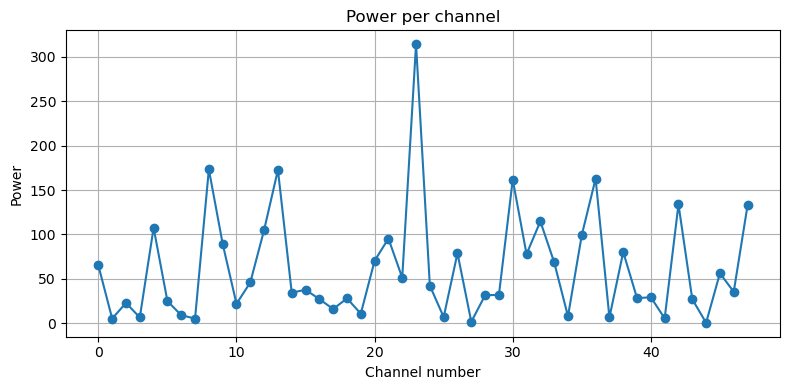

In [51]:
nffloat = 10 * fs / ff # Window size, chosen to contain 10 cycles of the frequency of interest
nf = 200#int(2 ** np.ceil(np.log2(nffloat)))
fr = fs / nf # Frequency resolution per bin [Hz]
bin = round(ff / fr) # Bin number of the frequency of interest
factual = bin * fr # Frequency of the bin [Hz]
print("Frequency of interest: ", ff)
print(f"Window size: {nf} ({nf/fs*1000.0} ms)")
print("Selected bin: ", bin)
print("Frequency of this bin: ", factual)
print(Draw.shape)
dft, step = g.goertzel(Draw, bin, nf, 0.0, True, False)
dft += g.goertzel(Draw, bin-1, nf, 0.0, True, False)[0]
print("DFT shape: ", dft.shape)
print("Step size: ", step)
# print("Goertzel result: ", res)
# Power of frequency bin
P = np.abs(dft) ** 2

# Plot the power per channel
plt.figure(figsize=(8, 4))
plt.plot(np.arange(0, N_ch), P[0,:], 'o-')
plt.title('Power per channel')
plt.xlabel('Channel number')
plt.ylabel('Power')
plt.grid()
plt.tight_layout()
plt.show()



### Cross-correlation matrix

Cross-correlation matrices are equal after normalization (DeepWaveAccel vs. reference)


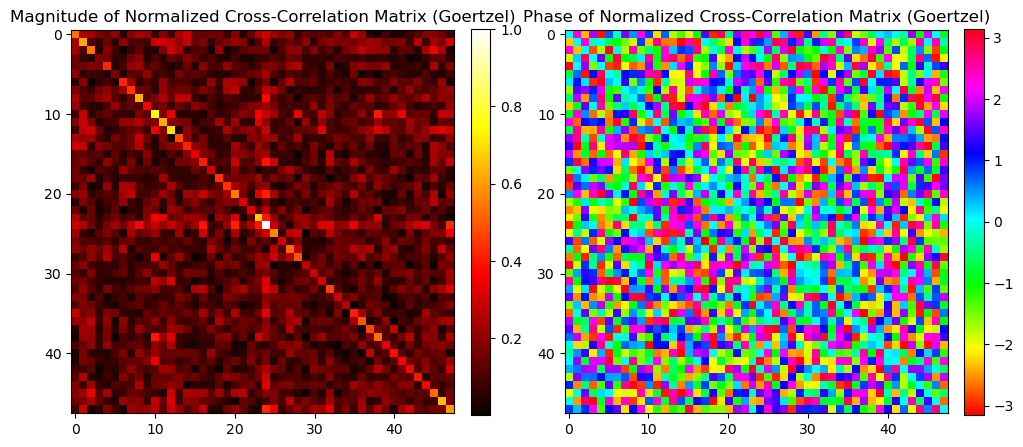

[1.15665260e-03 3.11316901e+00 6.80715180e+00 1.35685380e+01
 3.55813075e-01 3.89058721e+00 5.70668069e+00 9.47418210e+00
 3.61373560e-01 4.64809433e-01 4.50601814e-01 1.27586626e-01
 4.07496085e-02 4.91242699e-01 4.88182985e-02 9.39928961e-01
 6.50035128e-02 2.31516340e-01 5.04412958e-01 6.65889180e-02
 1.10217636e-01 2.06870424e-01 2.73179635e+00 2.28602363e+00
 1.31368457e-02 5.55144347e-02 5.03202334e-03 2.91918004e-02
 6.71022125e-01 9.70285528e-03 1.15380574e-03]


In [ ]:
# Compute the cross-correlation matrix using the Goertzel output (res)
# Each entry (i, j) is the correlation between channel i and channel j at the frequency bin of interest

# Calculate and store all correlation matrices using EMA for each frame
alpha = 0 #0.95 # EMA smoothing factor, 0 == no smoothing
R = np.zeros((N_ch, N_ch), dtype=np.complex128)
R_all = []  # List to store R at each step

# Calculate and store all correlation matrices using EMA for each frame
for frame in dft:
    outer = np.outer(np.conj(frame), frame)
    R = (1 - alpha) * outer + alpha * R
    R_all.append(R.copy())
R_all = np.stack(R_all)

# Group and sum every 9 resulting correlation matrices (only when not using EMA)
if alpha == 0:
    R_all = R_all[:(R_all.shape[0] // 9) * 9].reshape(-1, 9, N_ch, N_ch).sum(axis=1)
N_frames = R_all.shape[0]

# Compare all frames: normalized Goertzel vs. DeepWave reference
for sel in range(N_frames):
    S, _, _ = sampler.decode(Df[sel])
    R_norm = R_all[sel] / np.max(np.abs(R_all[sel]))
    S_norm = S / np.max(np.abs(S))
    if not np.allclose(R_norm, S_norm, atol=1e-6):
        print(f"Difference found in frame {sel}:")
        break
else:
    print("Cross-correlation matrices are equal after normalization (DeepWaveAccel vs. reference)")

# Display the magnitude and the phase of the normalized cross-correlation matrix (Goertzel)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
im = plt.imshow(np.abs(R_norm), cmap='hot', interpolation='nearest')
plt.title('Magnitude of Normalized Cross-Correlation Matrix (Goertzel)')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 2, 2)
plt.imshow(np.angle(R_norm), cmap='hsv', interpolation='nearest')
plt.title('Phase of Normalized Cross-Correlation Matrix (Goertzel)')
plt.colorbar(fraction=0.046, pad=0.04)

# Compare against normalized DeepWave reference
# plt.subplot(4, 1, 3)
# diff_mag = np.abs(R_norm) - np.abs(S_norm)
# im = plt.imshow(diff_mag, cmap='bwr', interpolation='nearest', vmin=0, vmax=1)
# plt.title('Difference in Magnitude (Goertzel - Reference, normalized)')
# plt.colorbar(im)

# # Show the phase difference (Goertzel - Reference), range -pi to pi
# plt.subplot(4, 1, 4)
# diff_phase = np.angle(R_norm) - np.angle(S_norm)
# diff_phase = (diff_phase + np.pi) % (2 * np.pi) - np.pi  # wrap to [-pi, pi]
# plt.imshow(diff_phase, cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
# plt.title('Phase Difference (Goertzel - Reference, normalized), [-π, π]')
# plt.colorbar(ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi], format='%.2f')

# TODO: Current problem: exploding values. need normalization maybe??
plt.tight_layout()
plt.show()
print(np.max(np.abs(R_all), axis=(1,2)))


### Backprojection

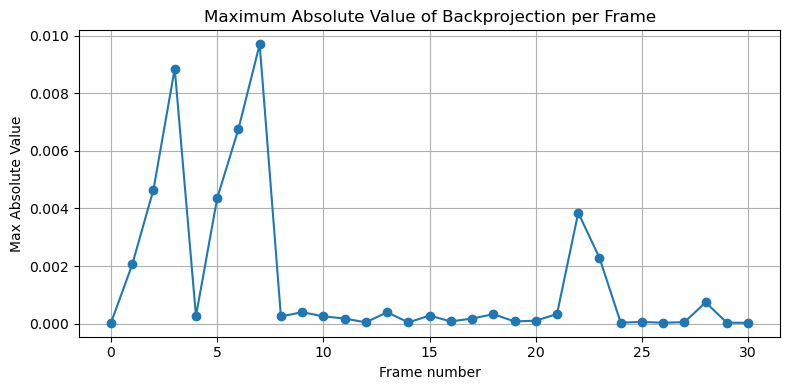

In [53]:
def backproject_hw_accurate(R, B, tau):
    """
    Compute y_i for a single correlation matrix (frame), using unique off-diagonal terms only.

    Parameters
    ----------
    R : ndarray
        Correlation matrix of shape (N_ch, N_ch)
    B : ndarray
        Beamforming matrix of shape (N_ch, N_vec)
    tau : ndarray
        Bias term of shape (N_vec,)

    Returns
    -------
    y : ndarray
        Output values y_i, shape (N_vec,)
    """
    N_ch, N_vec = B.shape
    y = np.zeros(N_vec, dtype=np.float64)

    diag_R = np.real(np.diag(R))

    for i in range(N_vec):
        b = B[:, i]

        # Diagonal term: Σ_jj * |b_ji|^2
        diag_term = np.sum(diag_R * np.abs(b)**2)

        # Off-diagonal term: sum_{j<k} 2 * Re( conj(b_j) * R_jk * b_k )
        offdiag_sum = 0.0
        for j in range(N_ch):
            for k in range(j + 1, N_ch):
                offdiag_sum += np.real(np.conj(b[j]) * R[j, k] * b[k])

        y[i] = diag_term + 2 * offdiag_sum

    return y + tau

def backproject_py_opt(R, B, tau):
    """
    Efficient computation of y_i = b_i^H * R * b_i for all beamformers b_i.

    Parameters
    ----------
    R : ndarray
        Correlation matrix (N_ch, N_ch)
    B : ndarray
        Beamforming matrix (N_ch, N_vec)
    tau : ndarray
        Bias term (N_vec,)

    Returns
    -------
    y : ndarray
        Output values y_i (N_vec,)
    """
    return  np.real(np.einsum('ij,ji->i', np.conj(B.T) @ R, B)) + tau


# Calculate the backprojection using both the HW-accurate method and the direct, Python-optimized method
# bpp_hw = backproject_hw_accurate(R_all[0], B, tau)
# bpp_py = backproject_py_opt(R_all[0], B, tau)

# # Compare the results
# if np.allclose(bpp_hw, bpp_py, atol=1e-6):
#     print("Backprojection results are equal (Goertzel vs. reference)")
# else:
#     print("Backprojection results differ between Goertzel and reference implementation.")

bpp = np.zeros((N_frames, B.shape[1]), dtype=np.float64)
for i in range(N_frames):
    bpp[i] = backproject_py_opt(R_all[i], B, tau)
    
# Plot the maximum abs value per frame
plt.figure(figsize=(8, 4))
plt.plot(np.arange(0, N_frames), np.max(np.abs(bpp), axis=1), 'o-')
plt.title('Maximum Absolute Value of Backprojection per Frame')
plt.xlabel('Frame number')
plt.ylabel('Max Absolute Value')
plt.grid()
plt.tight_layout()
plt.show()

### Plot backprojected result before deblurring

In [54]:
import plotly.graph_objects as go
import matplotlib.tri as mtri
from astropy.coordinates import Angle
import astropy.units as u

def wrapped_rad2deg(lat_r, lon_r):
    """
    Converts latitude/longitude from radians to degrees.
    Longitude output is wrapped to [-180, 180) degrees.
    """
    lat_d = Angle(lat_r, unit=u.rad).to_value(u.deg)
    lon_d = Angle(lon_r, unit=u.rad).wrap_at(180 * u.deg).to_value(u.deg)
    return lat_d, lon_d

def cart2eq(x, y, z):
    """
    Convert cartesian coordinates to spherical (r, lat, lon).
    lat: latitude in radians [-pi/2, pi/2]
    lon: longitude in radians [-pi, pi]
    """
    r = np.sqrt(x**2 + y**2 + z**2)
    lat = np.arcsin(z / r)
    lon = np.arctan2(y, x)
    return r, lat, lon

def eq2cart(r, lat, lon):
    """
    Convert spherical (r, lat, lon) to cartesian coordinates.
    """
    x = r * np.cos(lat) * np.cos(lon)
    y = r * np.cos(lat) * np.sin(lon)
    z = r * np.sin(lat)
    return np.vstack((x, y, z))


def draw_interactive_sky_mesh(I, R, mask_lon=None, catalog=None, cmap='Inferno'):
    """
    Interactive 3D spherical sky map using intensity values.

    Parameters
    ----------
    I : (N,) ndarray
        Intensity values per direction.
    R : (3, N) ndarray
        Cartesian coordinates (x, y, z) of array elements.
    mask_lon : (N,) ndarray of bool, optional
        Boolean mask to filter longitudes (e.g. within [-180, 180]).
    catalog : object, optional
        Catalog with `.xyz` (3, N) Cartesian coordinates.
    cmap : str
        Plotly color scale name (e.g. 'Inferno', 'Viridis', etc.).

    Returns
    -------
    fig : plotly.graph_objects.Figure
        Interactive mesh figure.
    """
    
    # Convert full R to (lat, lon) and filter longitude
    _, lat, lon = cart2eq(R[0], R[1], R[2])
    _, lon_deg = wrapped_rad2deg(lat, lon)
    mask = (lon_deg >= -180) & (lon_deg <= 180)
    R_equatorial = eq2cart(1, lat[mask], lon[mask])

    x, y, z = R_equatorial
    if mask_lon is not None:
        x, y, z = x[mask_lon], y[mask_lon], z[mask_lon]
        I = I[mask_lon]

    # Convert to spherical coordinates for triangulation
    theta = np.arccos(np.clip(z, -1, 1))  # polar angle
    phi = np.mod(np.arctan2(y, x), 2 * np.pi)  # azimuth in [0, 2pi]

    # Triangulation in angular domain
    triang = mtri.Triangulation(phi, theta)

    # Normalize intensity
    I_norm = np.clip((I - I.min()) / (I.ptp() + 1e-12), 0, 1)

    fig = go.Figure()

    # Mesh3D: surface visualization
    fig.add_trace(go.Mesh3d(
        x=x, y=y, z=z,
        i=triang.triangles[:, 0],
        j=triang.triangles[:, 1],
        k=triang.triangles[:, 2],
        intensity=I_norm,
        colorscale=cmap,
        showscale=True,
        opacity=1.0,
        lighting=dict(ambient=0.7, diffuse=1.0, specular=0.05, roughness=0.9),
        lightposition=dict(x=100, y=100, z=100),
        name='Sky Intensity',
    ))

    # Overlay catalog sources
    if catalog is not None and hasattr(catalog, "xyz"):
        cx, cy, cz = catalog.xyz
        fig.add_trace(go.Scatter3d(
            x=cx, y=cy, z=cz,
            mode='markers',
            marker=dict(color='white', size=3),
            name='Catalog Sources'
        ))

    fig.update_layout(
        title='3D Spherical Sky Map (Interactive Mesh)',
        scene=dict(
            xaxis=dict(showbackground=False, visible=False),
            yaxis=dict(showbackground=False, visible=False),
            zaxis=dict(showbackground=False, visible=False),
            aspectmode='data',
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.5)),
        ),
        template='plotly_dark',
        margin=dict(l=0, r=0, b=0, t=30)
    )

    return fig

fig = draw_interactive_sky_mesh(bpp[2], Df.R)
fig.show()

### Deblurring

In [57]:
import Laplacian as lap
import Deblur as deblur
# Step 1. Prepare the Laplacian matrix. Calculate from R, use threshold to remove insignificant connections and store it in banded matrix format.

laplacian, rho = lap.laplacian_scipy(Df.R)
laplacian = laplacian.todia()
laplacian_banded = lap.sparsify_band_symmetric(laplacian, threshold=1e-4)
print("Reduced Laplacian banded matrix to {} diagonals".format(laplacian_banded.shape[0]))

# Step 2. Prepare seed image. Seed image is zero for first frame, the following frames use the previous deblurred image as a seed
x = np.zeros((N_px,))

deblurred_images = np.zeros((N_frames, N_px))
# bpp[1] = bpp[0]

for i in range(N_frames):
    for layer in range(N_layer):
        y = deblur.chebyshev_conv(laplacian, x, theta)
        deblurred_images[i] = deblur.retanh_activation(y+bpp[i]) 
        x = deblurred_images[i]
    

# Step 3. Plot the deblurred images
fig = draw_interactive_sky_mesh(deblurred_images[2], Df.R)
fig.show()

Reduced Laplacian banded matrix to 7 diagonals
